In [1]:
!pip install workalendar

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 18.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pymeeus: filename=PyMeeus-0.5.12-py3-none-any.whl size=732001 sha256=d741d36b681d4b1e001c2eb375d2bd925aa7ccaeac92de5e25d8fef7823cf5db
  Stored in directory: /root/.cache/pip/wheels/d6/67/78/aa2e8d108639dd23a5e9e72a4fc88bb44f5541894382712f48
Successfully built pymeeus


In [2]:
import pandas as pd
from google.colab import auth
from google.colab import files
from google.oauth2 import service_account
import matplotlib.pyplot as plt
from prophet import Prophet
from workalendar.america import Brazil
from matplotlib.ticker import FuncFormatter


In [5]:
!gcloud auth activate-service-account --key-file={'/content/gcp-tech-challenge-d6e951545c21.json'}
!gsutil cp gs://{'raw_data_ipea'}/ipea_df.csv ipea_df.csv
df = pd.read_csv('/content/ipea_df.csv')

Activated service account credentials for: [gcp-tech-challenge@gcp-tech-challenge.iam.gserviceaccount.com]
Copying gs://raw_data_ipea/ipea_df.csv...
/ [1 files][176.4 KiB/176.4 KiB]                                                
Operation completed over 1 objects/176.4 KiB.                                    


In [6]:
df.head()


,Data,Preco_petroleo
0,18/06/2024,8479
1,17/06/2024,8245
2,14/06/2024,8149
3,13/06/2024,8144
4,12/06/2024,8052


In [7]:
df.head()

,Data,Preco_petroleo
0,18/06/2024,8479
1,17/06/2024,8245
2,14/06/2024,8149
3,13/06/2024,8144
4,12/06/2024,8052


In [8]:
df.isnull().sum()

Data              0
Preco_petroleo    0
dtype: int64

In [9]:
df.duplicated().sum()

0

In [10]:
df = df.rename(columns={'Preco_petroleo': 'y'})
df = df.rename(columns={'Data': 'ds'})
df['ds'] = pd.to_datetime(df['ds'], format='%d/%m/%Y', errors='coerce')


In [11]:
df['y'] = df['y'].astype(int)
df['y'] = df['y'].apply(lambda x: float(f"{x // 100}.{x % 100:02}"))

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11194 entries, 0 to 11193
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      11194 non-null  datetime64[ns]
 1   y       11194 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 175.0 KB


In [13]:
# Calcular a variação percentual nos preços
df['Variação Percentual'] = df['y'].pct_change() * 100

# Encontrar os 10 maiores aumentos e 10 maiores quedas
maiores_aumentos = df.nlargest(10, 'Variação Percentual')
maiores_quedas = df.nsmallest(10, 'Variação Percentual')

# Exibir os resultados
print("10 Maiores Aumentos nos Preços do Petróleo Brent")
print(maiores_aumentos[['ds', 'y', 'Variação Percentual']])

print("\n10 Maiores Quedas nos Preços do Petróleo Brent")
print(maiores_quedas[['ds', 'y', 'Variação Percentual']])


10 Maiores Aumentos nos Preços do Petróleo Brent
              ds      y  Variação Percentual
1058  2020-04-20  17.36            90.350877
10258 1991-01-16  30.28            43.507109
1072  2020-03-30  19.19            29.225589
1088  2020-03-06  45.60            29.068780
1065  2020-04-08  25.22            24.666337
1081  2020-03-17  27.97            22.729267
7553  2001-09-21  25.17            22.006786
10319 1990-10-19  33.20            20.947177
4995  2008-12-08  43.83            18.331533
1083  2020-03-13  33.00            17.941387

10 Maiores Quedas nos Preços do Petróleo Brent
              ds      y  Variação Percentual
1057  2020-04-21   9.12           -33.769063
1070  2020-04-01  14.97           -26.037549
4970  2009-01-04  35.82           -21.858639
1048  2020-05-04  20.40           -19.874313
1069  2020-04-02  20.24           -16.810522
10263 1991-01-09  22.35           -15.914221
8440  1998-03-20  12.35           -15.003441
5047  2008-10-16  64.14           -13.755547
277

In [14]:
df.head()
df.to_excel('/content/arquivo.xlsx', index=False)
from google.colab import files
files.download('/content/arquivo.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
df.describe().round(2)

,ds,y,Variação Percentual
count,11194,11194.00,11193.00
mean,2006-08-21 17:32:32.117205504,53.08,0.02
min,1987-05-20 00:00:00,9.10,-33.77
25%,1998-05-28 06:00:00,20.51,-1.29
50%,2007-04-08 12:00:00,48.34,-0.02
75%,2015-01-08 18:00:00,76.57,1.22
max,2024-06-18 00:00:00,143.95,90.35
std,NaN,33.22,2.77


In [16]:
# Definir as datas de início e fim para o filtro
start_date = '2014-06-01'
end_date = '2024-06-01'
# Filtrar o DataFrame usando o método loc
df5anos = df.loc[(df['ds'] >= start_date) & (df['ds'] <= end_date)]
df5anos.shape

(3007, 3)

<class 'pandas.core.frame.DataFrame'>
Index: 3007 entries, 12 to 3018
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ds                   3007 non-null   datetime64[ns]
 1   y                    3007 non-null   float64       
 2   Variação Percentual  3007 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 94.0 KB


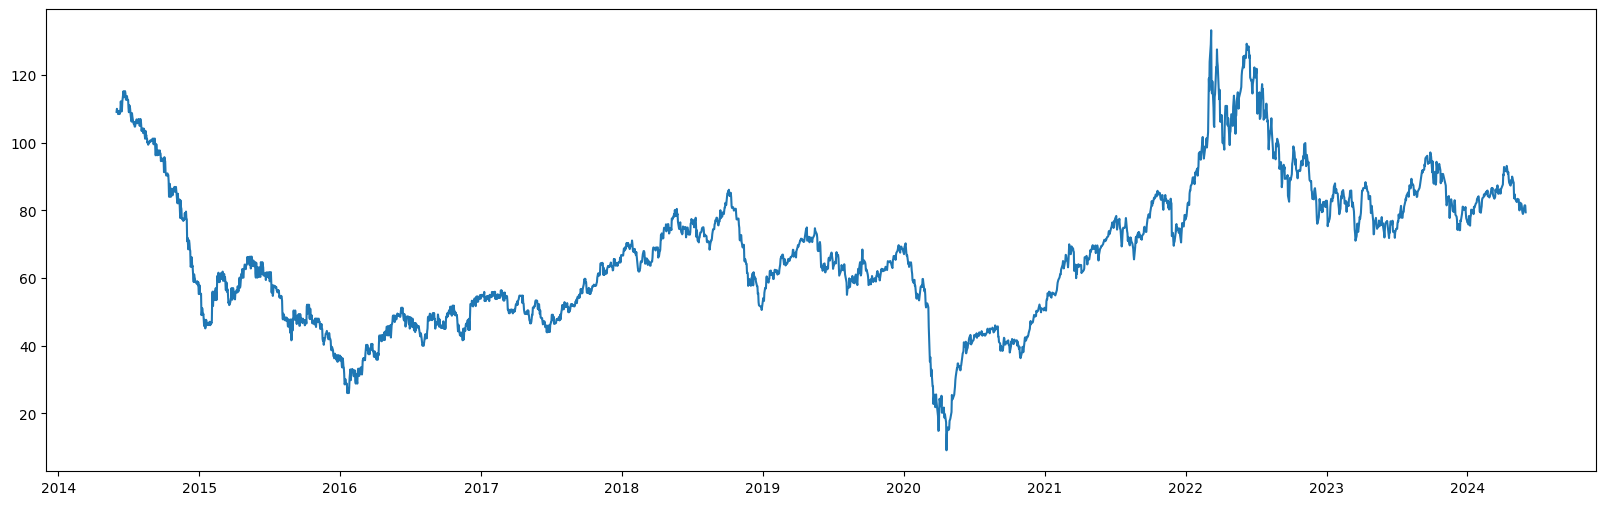

In [17]:
plt.figure(figsize=(20, 6))
plt.plot(df5anos.ds, df5anos.y)
df5anos.info()

In [18]:
#Dividindo a base em treino (75%) e teste (25%)
train_data = df5anos.sample(frac=0.75, random_state=0)
test_data = df5anos.drop(train_data.index)
print(f'TAMANHO DA BASE DE TREINAMENTO: {train_data.shape}')
print(f'TAMANHO DA BASE DE TESTE: {test_data.shape}')

TAMANHO DA BASE DE TREINAMENTO: (2255, 3)
TAMANHO DA BASE DE TESTE: (752, 3)


In [19]:
# Importando uma biblioteca que consolida os dias úteis do Brasil para eliminar da previsão os feriados e finais de semana, uma vez que a bolsa não opera nesses dias.
#
calendario_brasileiro = Brazil()
# Pegando os feriados brasileiros apenas de 2024
feriados_2024 = calendario_brasileiro.holidays(2024)
# Convertendo as datas dos feriados
df_feriados = pd.DataFrame(feriados_2024, columns=['Data', 'Feriado'])
# Criando um DF com todas as datas de 2024
datas_2024 = pd.date_range(start='2024-01-01', end='2024-12-31')
# Aqui ele filtra todos os dias que são finais de semana
dias_nao_uteis = datas_2024[(~datas_2024.isin(df_feriados['Data'])) & (datas_2024.weekday >= 5)]
# Cria a base com os dias de sábado e domingo
df_dias_nao_uteis = pd.DataFrame({'Data': dias_nao_uteis, 'Dia útil': False})
# Juntando os DFs de feriados e finais de semana
df_feriados['Data'] = pd.to_datetime(df_feriados['Data'])
df_dias_nao_uteis['Data'] = pd.to_datetime(df_dias_nao_uteis['Data'])

# Concatenando e ordenando os dataframes
df_dias_nao_uteis = pd.concat([df_feriados, df_dias_nao_uteis]).sort_values(by='Data').reset_index(drop=True)

print(df_dias_nao_uteis)

          Data        Feriado Dia útil
0   2024-01-01       New year      NaN
1   2024-01-06            NaN    False
2   2024-01-07            NaN    False
3   2024-01-13            NaN    False
4   2024-01-14            NaN    False
..         ...            ...      ...
103 2024-12-21            NaN    False
104 2024-12-22            NaN    False
105 2024-12-25  Christmas Day      NaN
106 2024-12-28            NaN    False
107 2024-12-29            NaN    False

[108 rows x 3 columns]


In [20]:
modelo = Prophet(daily_seasonality=True)
modelo.fit(train_data)
dataFramefuture = modelo.make_future_dataframe(periods=150, freq='D')
dataFramefuture = dataFramefuture[~dataFramefuture['ds'].isin(df_dias_nao_uteis['Data'])]
previsao = modelo.predict(dataFramefuture)
previsao.head()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpownt23sh/c4kmdbjd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpownt23sh/bl6z26e4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71668', 'data', 'file=/tmp/tmpownt23sh/c4kmdbjd.json', 'init=/tmp/tmpownt23sh/bl6z26e4.json', 'output', 'file=/tmp/tmpownt23sh/prophet_modellrjm911r/prophet_model-20240709211105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:11:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:11:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-06-01,108.634526,105.739554,125.239500,108.634526,108.634526,6.716026,6.716026,6.716026,3.613839,...,0.222913,0.222913,0.222913,2.879273,2.879273,2.879273,0.0,0.0,0.0,115.350552
1,2014-06-02,108.434048,105.700358,124.945444,108.434048,108.434048,6.741197,6.741197,6.741197,3.613839,...,0.301711,0.301711,0.301711,2.825647,2.825647,2.825647,0.0,0.0,0.0,115.175244
2,2014-06-03,108.233569,103.822289,123.856703,108.233569,108.233569,6.439750,6.439750,6.439750,3.613839,...,0.052841,0.052841,0.052841,2.773069,2.773069,2.773069,0.0,0.0,0.0,114.673319
3,2014-06-04,108.033090,104.947713,123.786326,108.033090,108.033090,6.340641,6.340641,6.340641,3.613839,...,0.003068,0.003068,0.003068,2.723734,2.723734,2.723734,0.0,0.0,0.0,114.373732
4,2014-06-05,107.832611,103.942170,123.517211,107.832611,107.832611,6.066920,6.066920,6.066920,3.613839,...,-0.226566,-0.226566,-0.226566,2.679646,2.679646,2.679646,0.0,0.0,0.0,113.899531


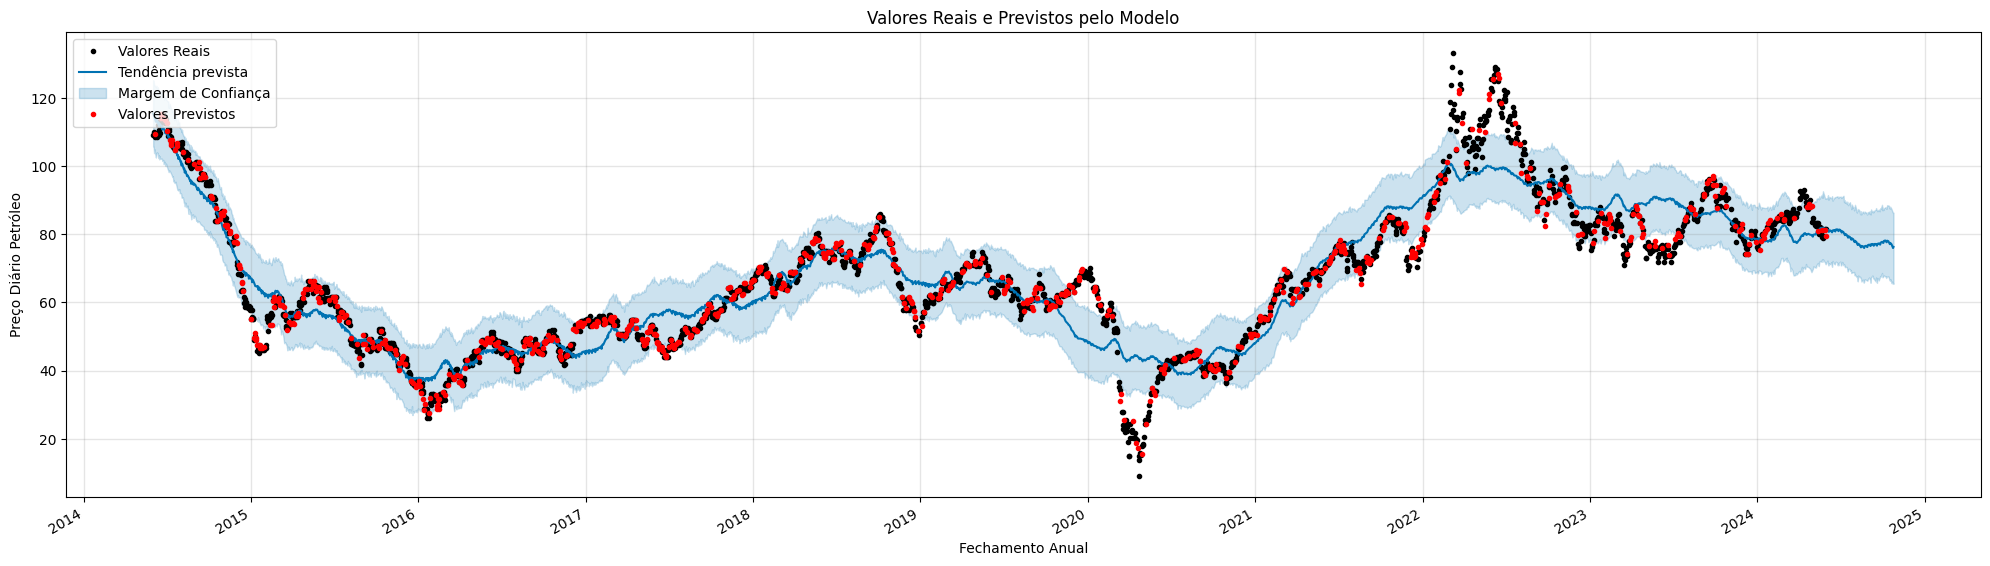

In [21]:
import matplotlib.dates as mdates
modelo.plot(previsao, figsize=(20,6));
plt.plot(test_data['ds'], test_data['y'], '.r')

# Configuração do eixo X para exibir anos
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Ajuste para evitar sobreposição de datas
plt.gcf().autofmt_xdate()

# Adicione título e rótulos dos eixos

plt.title('Valores Reais e Previstos pelo Modelo')
plt.xlabel('Fechamento Anual')
plt.ylabel('Preço Diário Petróleo')

plt.legend([
    'Valores Reais',
    'Tendência prevista',
    'Margem de Confiança',
    'Valores Previstos'
], loc='upper left')

plt.show()


In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao[previsao_cols]
valores_reais = train_data[valores_reais_cols]

resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

mape = np.mean(resultados['erro_percentual_absoluto'])

# Calcular o MSE (Erro Quadrático Médio)
mse = mean_squared_error(resultados['y'], previsao.loc[:len(resultados)-1, 'yhat'])

# Calcular o MAE (Erro Absoluto Médio)
mae = mean_absolute_error(resultados['y'], previsao.loc[:len(resultados)-1, 'yhat'])

# Calcular o MdAPE (Erro Percentual Absoluto Médio na Mediana)
mediana_y = resultados['y'].median()
mdape = np.mean(np.abs((resultados['y'] - resultados['yhat']) / mediana_y)) * 100

# Calcular o RMSE
rmse = np.sqrt(mean_squared_error(resultados['y'], previsao.loc[:len(resultados)-1, 'yhat']))
acuracia = 100 - mape


print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape:.2f}%")
print(f"Acurácia: {acuracia:.2f}%")


MSE: 56.9882467018594
RMSE: 7.549056013956937
MAE: 5.531035398546784
MAPE: 9.96%
Acurácia: 90.04%


In [23]:
from prophet.plot import add_changepoints_to_plot

modelo_changepoints = Prophet(n_changepoints=5)
modelo_changepoints.fit(train_data)
dataFramefuture = modelo_changepoints.make_future_dataframe(periods=30, freq='D')
previsao_changepoints = modelo_changepoints.predict(dataFramefuture)
previsao_changepoints.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpownt23sh/z7vi5fne.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpownt23sh/rmx_pon7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47447', 'data', 'file=/tmp/tmpownt23sh/z7vi5fne.json', 'init=/tmp/tmpownt23sh/rmx_pon7.json', 'output', 'file=/tmp/tmpownt23sh/prophet_model8n46_uer/prophet_model-20240709211108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:11:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:11:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-06-01,103.529604,94.335304,119.054668,103.529604,103.529604,2.823536,2.823536,2.823536,-0.133840,-0.133840,-0.133840,2.957377,2.957377,2.957377,0.0,0.0,0.0,106.353140
1,2014-06-02,103.397366,93.981465,118.702049,103.397366,103.397366,3.488602,3.488602,3.488602,0.471259,0.471259,0.471259,3.017343,3.017343,3.017343,0.0,0.0,0.0,106.885969
2,2014-06-03,103.265129,94.611075,118.640465,103.265129,103.265129,3.312480,3.312480,3.312480,0.232825,0.232825,0.232825,3.079655,3.079655,3.079655,0.0,0.0,0.0,106.577609
3,2014-06-04,103.132892,93.787528,117.990510,103.132892,103.132892,3.126255,3.126255,3.126255,-0.018195,-0.018195,-0.018195,3.144450,3.144450,3.144450,0.0,0.0,0.0,106.259146
4,2014-06-05,103.000654,93.278870,118.122019,103.000654,103.000654,3.077834,3.077834,3.077834,-0.133796,-0.133796,-0.133796,3.211630,3.211630,3.211630,0.0,0.0,0.0,106.078489


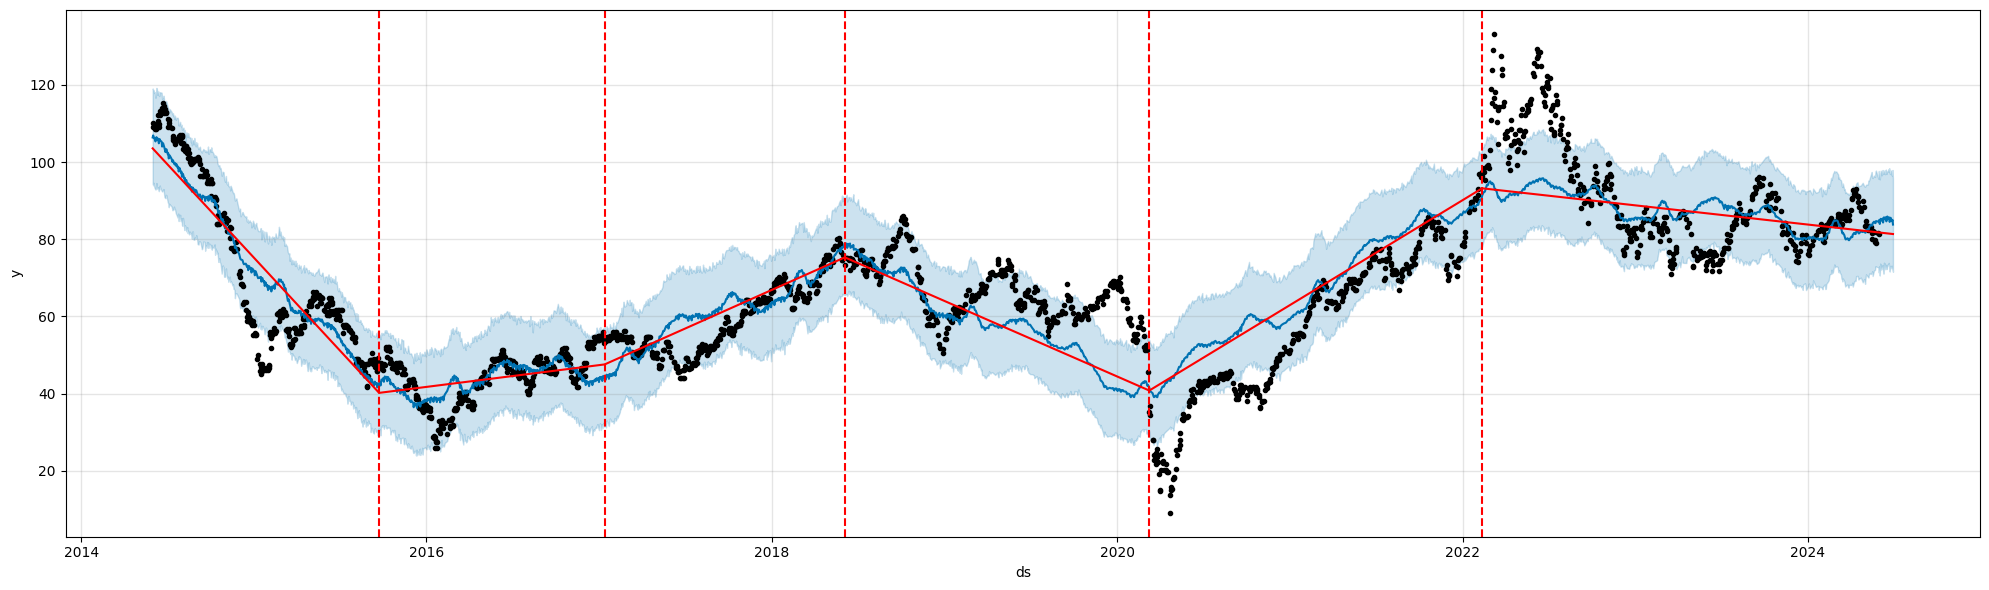

In [24]:
fig = modelo_changepoints.plot(previsao_changepoints, figsize=(20,6));
a = add_changepoints_to_plot(fig.gca(), modelo_changepoints, previsao_changepoints)

In [25]:
previsao_cols1 = ['ds', 'yhat']
valores_reais_cols1 = ['ds', 'y']

previsao_changepoints = previsao_changepoints[previsao_cols1]
valores_reais1 = train_data[valores_reais_cols1]

resultados1 = pd.merge(previsao_changepoints, valores_reais1, on='ds', how='inner')

resultados1['erro_percentual_absoluto'] = np.abs((resultados1['y'] - resultados1['yhat']) / resultados1['y']) * 100

mape1 = np.mean(resultados1['erro_percentual_absoluto'])

# Calcular o MSE (Erro Quadrático Médio)
mse1 = mean_squared_error(resultados1['y'], previsao_changepoints.loc[:len(resultados1)-1, 'yhat'])

# Calcular o MAE (Erro Absoluto Médio)
mae1 = mean_absolute_error(resultados1['y'], previsao_changepoints.loc[:len(resultados1)-1, 'yhat'])

# Calcular o MdAPE (Erro Percentual Absoluto Médio na Mediana)
mediana_y1 = resultados1['y'].median()
mdape1 = np.mean(np.abs((resultados1['y'] - resultados1['yhat']) / mediana_y)) * 100

# Calcular o RMSE
rmse1 = np.sqrt(mean_squared_error(resultados1['y'], previsao_changepoints.loc[:len(resultados1)-1, 'yhat']))
acuracia1 = 100 - mape1


print(f"MSE: {mse1}")
print(f"RMSE: {rmse1}")
print(f"MAE: {mae1}")
print(f"MAPE: {mape1:.2f}%")
print(f"Acurácia: {acuracia1:.2f}%")

MSE: 92.0361709119674
RMSE: 9.593548400459936
MAE: 7.268274730279715
MAPE: 13.05%
Acurácia: 86.95%
